# Componentes de series de tiempo

In [1]:
# Paquetes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing

## Cargar datos

In [113]:
# importar datos
link = "https://raw.githubusercontent.com/AlvaroM31/Forecasting_aplicado_python/refs/heads/main/Introducci%C3%B3n_T%C3%A9cnico/data.csv"
data = pd.read_csv(link)
# pd.read_csv(link, index_col=0, parse_dates=True) # Forma simple de cargar los datos y evitarse la siguiente linea de codigo
#----------------------------------------------------------------------------------------
# Pero prefiero convertir en indice la columna fecha
data.set_index('Unnamed: 0',inplace=True)
data.head()#.info #type(data)

,ventas
Unnamed: 0,
2024-01-01,457.450712
2024-01-02,446.426035
2024-01-03,456.715328
2024-01-04,468.345448
2024-01-05,440.487699


El indice actualmente se cargó como un string, lo cual no debería suceder y es inconveniente futuramente para los modelos de forecasting, ya que la columna indice debe de ser de tipo fecha.
- Es por ello que se recomienda hacer esta conversión al inicio, *(al momento de cargar la data)*, en el tercer campo --> pd.read_csv(link, index_col=0, parse_dates=True).
- parse_dates significa --> analizar y convertir en fechas.
- index_col=0 significa, “la primera columna”, de la data se convertira en indice.

In [3]:
# type(data.index[0])
data['Unnamed: 0'] = pd.to_datetime(data.index)
data.set_index('Unnamed: 0', inplace=True)
# type(data.index[0])
data.index.name = None # Eliminar el nombre de la columna

In [4]:
data.head()

,ventas
2024-01-01,457.450712
2024-01-02,446.426035
2024-01-03,456.715328
2024-01-04,468.345448
2024-01-05,440.487699


## Análisis Exploratorio

In [5]:
data.describe()

,ventas
count,137.000000
mean,446.573949
std,72.415699
min,341.634336
25%,389.861260
50%,428.048735
75%,492.981193
max,621.484310


<Axes: >

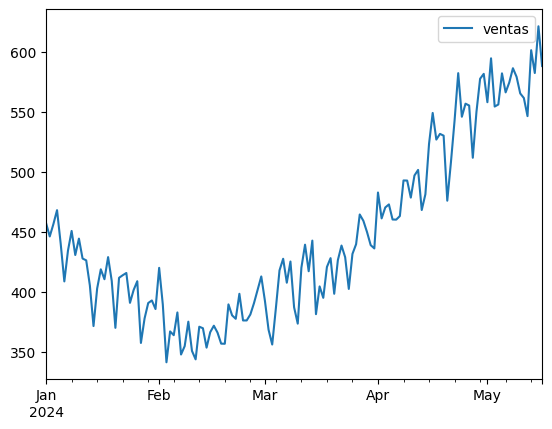

In [6]:
data.plot()

<Axes: >

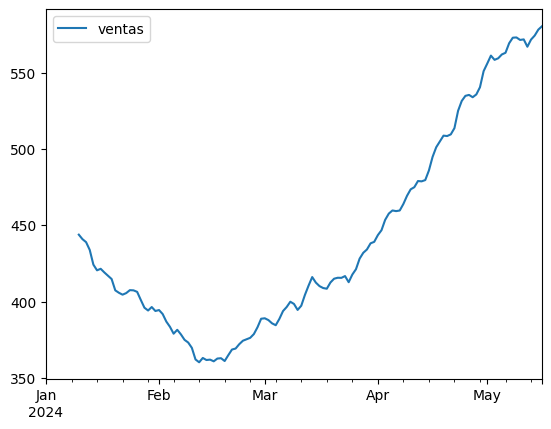

In [7]:
data.rolling(10).mean().plot() # rolling significa ventana móvil

## Análisis de tendecia

### 🔹 **Promedio móvil (rolling mean)**

Es un método que suaviza una serie de tiempo calculando el **promedio de los últimos *n* valores**. Se usa para reducir el "ruido" y resaltar la tendencia general.

📌 *Ejemplo:* Si usamos una ventana de 10 días, cada punto es el promedio de esos 10 días anteriores.
- rolling significa ventana móvil

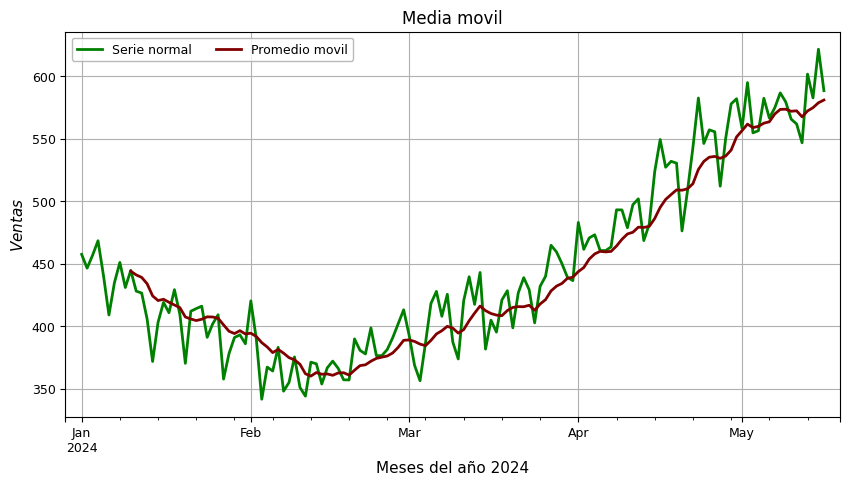

In [8]:
data.ventas.plot(figsize=(10,5), label = 'Serie normal',color = '#008000',lw = 2) # Puedo hacer lo mismo tambien plt.plot
data.ventas.rolling(10).mean().plot(label = 'Promedio movil',color='#800000', lw=2) # Cuando escribo ventas en rolling se pone en la misma grafica
plt.legend(fontsize=9,ncol= 2, edgecolor='#A9A9A9')
plt.tick_params(axis='both', labelsize=9)
plt.title('Media movil', fontsize=12)
plt.xlabel('Meses del año 2024', fontsize=11)
plt.ylabel('$Ventas$', fontsize=11)
plt.xlim(19720,19862) # Rango donde se ubicaran los meses (los meses se miden en numeros sistematicamente)
plt.grid(True)
plt.show()

### 🔹 **Promedio móvil exponencial (EWMA)**

Similar al promedio móvil, pero da **más peso a los datos recientes**, lo que lo hace más sensible a cambios. Es ideal para detectar giros rápidos en la tendencia.

📌 *Ejemplo:* Con `span=4`, los valores más nuevos tienen más influencia que los antiguos.
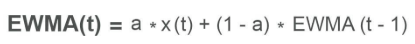

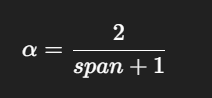

- mientras de tenga un span menor se recolecta menor información de tiempos muy pasados, y mas de tiempo recientes *(periodo anterior)*

In [9]:
data.ventas.ewm(span=5).mean().head()

,ventas
2024-01-01,457.450712
2024-01-02,450.835906
2024-01-03,453.620896
2024-01-04,459.737248
2024-01-05,452.347611


Graficandon los distintos tipos de media móvil exponencial

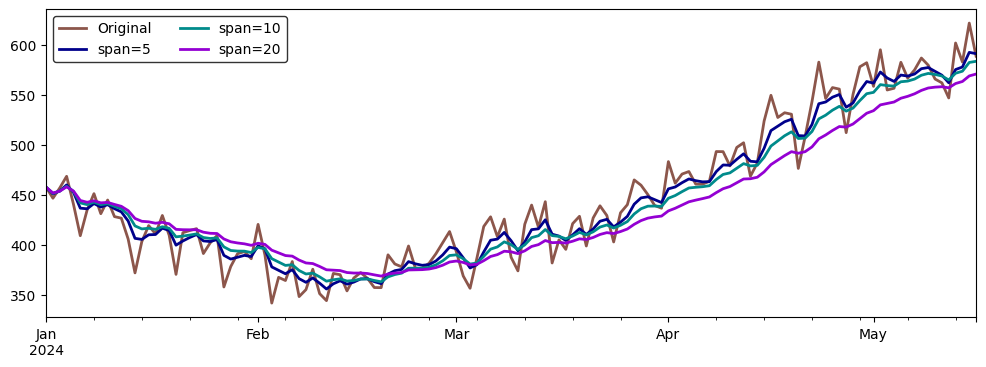

In [10]:
data.ventas.plot(figsize=(12,4), color='#8c564b', lw=2, label = 'Original')
data.ventas.ewm(span=5).mean().plot(color='#00008B',lw=2, label = 'span=5')
data.ventas.ewm(span=10).mean().plot(color='#008B8B',lw=2, label = 'span=10')
data.ventas.ewm(span=20).mean().plot(color='#9400D3',lw=2, label = 'span=20')

plt.legend(loc='upper left', ncol=2,edgecolor='#000000')
plt.savefig('EWMA.png',dpi=300,bbox_inches='tight') #Con esto descargo en 1 imagen
# bordes (bounding box) de la imagen se ajusten automáticamente al contenido de la figura, eliminando los espacios en blanco innecesarios alrededor.

plt.show()

### 🔹 **Tendencia LOESS (o LOWESS)**

Es un **suavizado local** que ajusta pequeños modelos de regresión a partes de los datos. A diferencia de los promedios, **no asume forma lineal** y se adapta mejor a cambios no lineales.

📌 *Ventaja:* Captura bien curvas suaves o cambios graduales sin necesidad de un modelo global.

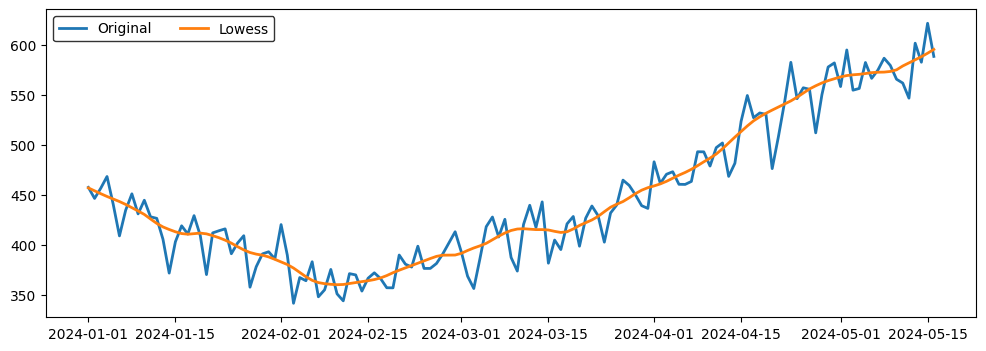

In [11]:
from statsmodels.nonparametric.smoothers_lowess import lowess
#su desventaja es que es demasiado sensible
#Es bueno cuando una serie tiene varias etapas
loess = lowess(data['ventas'], np.arange(len(data)), frac=0.1)# np.arange genera de 0,1, n-1
fig, ax = plt.subplots(figsize=(12,4))
plt.plot(data.index, data['ventas'], label='Original', lw=2)
plt.plot(data.index, loess[:,1], label = 'Lowess',lw=2) # loess[,1] suaviza la serie, la vuelve decimal
plt.legend(loc='upper left', ncol=2, edgecolor='#000000')
plt.show()

loess[:,1]
- Es como si escogiera la segunda columna solamente, porqe loess genera 2 columnas: indice y serie suavizada.
- Si fuera solamente loess[:,0] se escogeria el indice

## Análisis de estacionalidad

### Días de la semana

In [13]:
data.index # Asegúrate de tener el índice como datetime (Por eso es importante el parse_date)

DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09', '2024-01-10',
               ...
               '2024-05-07', '2024-05-08', '2024-05-09', '2024-05-10',
               '2024-05-11', '2024-05-12', '2024-05-13', '2024-05-14',
               '2024-05-15', '2024-05-16'],
              dtype='datetime64[ns]', length=137, freq=None)

In [16]:
data.index.isocalendar().head()

,year,week,day
2024-01-01,2024,1,1
2024-01-02,2024,1,2
2024-01-03,2024,1,3
2024-01-04,2024,1,4
2024-01-05,2024,1,5


####Creación de columnas semanas y días

In [17]:
data['Semana'] = data.index.isocalendar().week
data['Día_semana'] = data.index.day_name() # Puedes usar day si prefieres un número

In [20]:
data.head()

,ventas,Semana,Día_semana
2024-01-01,457.450712,1,Monday
2024-01-02,446.426035,1,Tuesday
2024-01-03,456.715328,1,Wednesday
2024-01-04,468.345448,1,Thursday
2024-01-05,440.487699,1,Friday


In [27]:
data.head()

,ventas,Semana,Día_semana
2024-01-01,457.450712,1,Monday
2024-01-02,446.426035,1,Tuesday
2024-01-03,456.715328,1,Wednesday
2024-01-04,468.345448,1,Thursday
2024-01-05,440.487699,1,Friday


Ordenar los nombres desde lunes a domingo

In [24]:
dias = ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']

Transformar de ingles a español

In [32]:
data.pivot_table(index='Semana', columns='Día_semana', values='ventas')[dias]

Día_semana,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Semana,,,,,,,
1,457.450712,446.426035,456.715328,468.345448,440.487699,408.987946,434.688192
2,451.011521,430.957884,444.638401,428.048735,426.514054,405.629434,371.800796
3,403.126233,419.065687,410.807533,429.213710,409.379639,370.315444,411.984732
4,414.113355,416.012923,391.128777,401.834259,409.163839,357.735096,378.135470
5,390.990420,393.124594,385.974401,420.284173,389.797542,341.634336,367.338174
6,364.187345,383.132954,348.104948,355.077209,375.452919,351.076999,344.070524
7,371.265276,369.983445,353.822170,366.702337,372.090418,366.356833,357.154274
8,357.054398,389.861260,380.723766,377.846170,398.675144,376.464993,376.469202
9,381.411737,390.861814,401.968951,413.133177,392.812386,368.715115,356.404975


In [33]:
# creando la primera tabla
tabla1 = data.pivot_table(index='Semana', columns='Día_semana', values='ventas')[dias]

Cambiando la tabla 1 sus columnas(dias de la semana) de ingles a español

In [44]:
diccionario = {
    'Monday':'Lunes',
    'Tuesday': 'Martes',
    'Wednesday': 'Miercoles',
    'Thursday' : 'Jueves',
    'Friday':'Viernes',
    'Saturday':'Sabado',
    'Sunday': 'Domingo'
}

In [46]:
# Lista en español
español = ['Lunes', 'Martes', 'Miercoles','Jueves', 'Viernes', 'Sabado', 'Domingo']

In [45]:
tabla1.rename(columns=diccionario, inplace=True)

####Graficar cada día en subplots

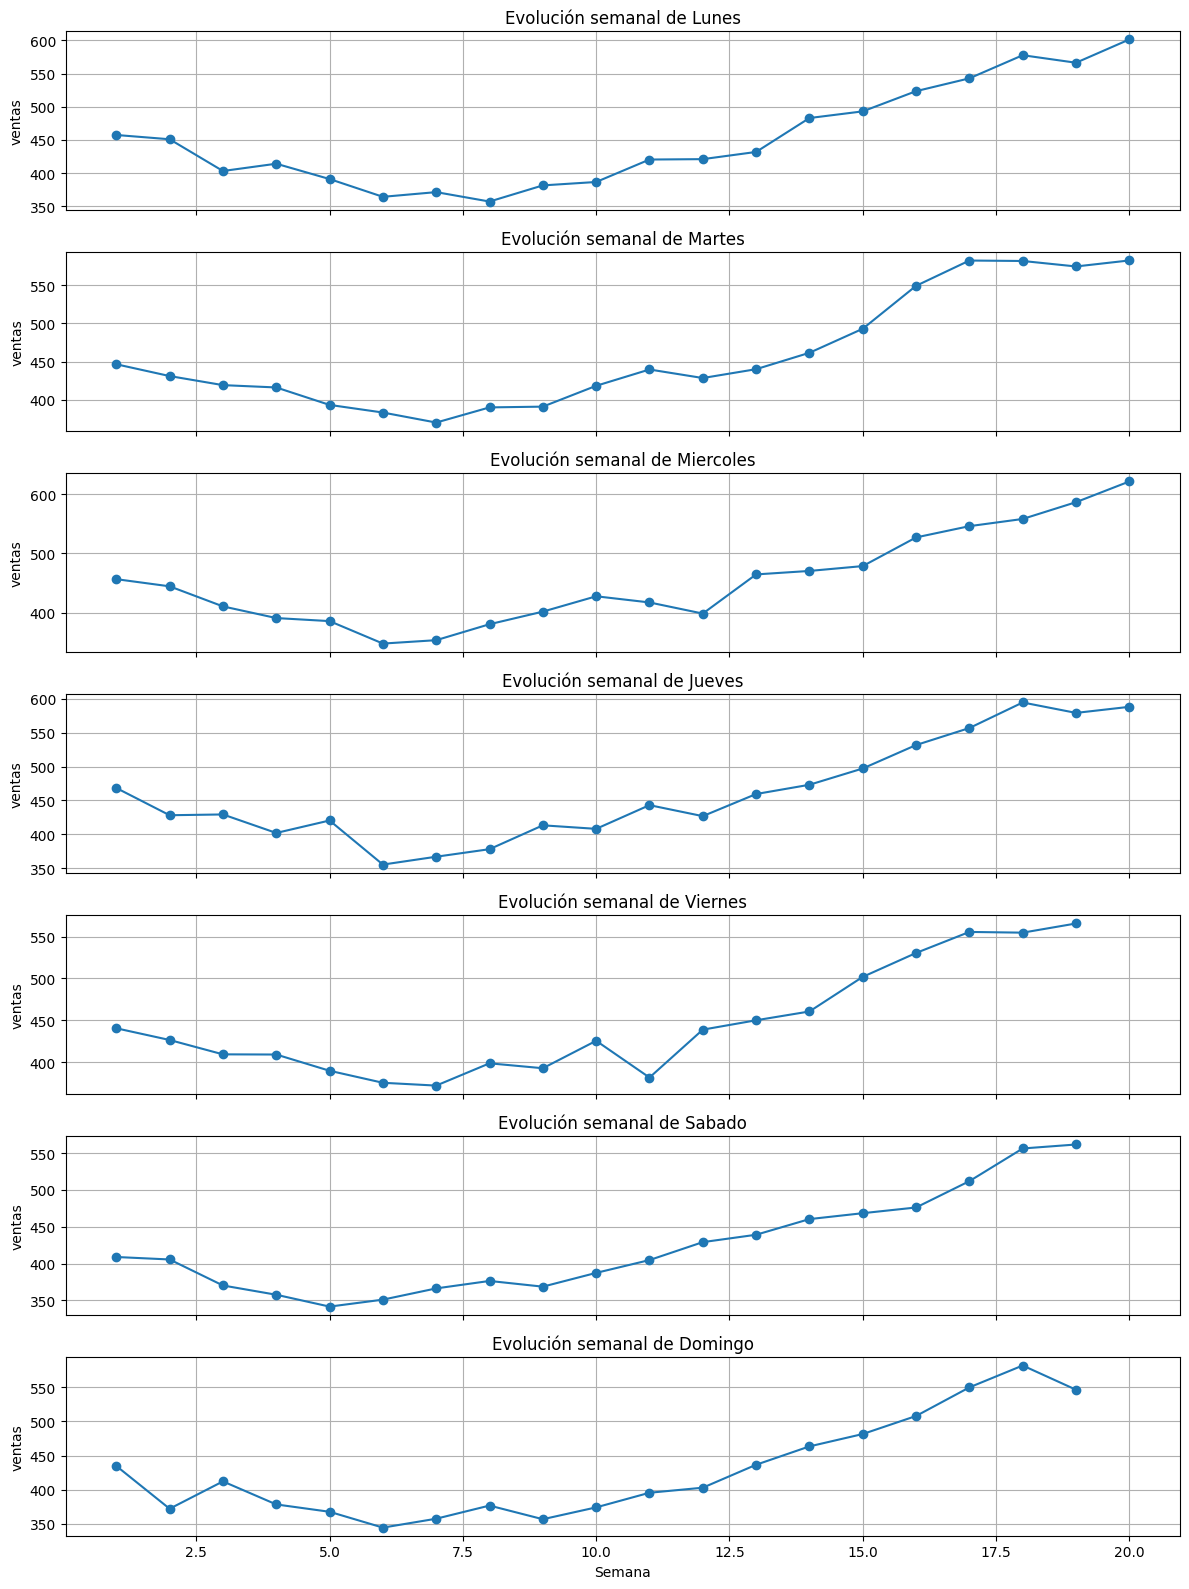

In [54]:
fig, axes = plt.subplots(7,1,figsize=(12,16),sharex=True)
#sharex sirve para compartir el mismo eje x en todos y solos se muestre al final
for i, dia in enumerate(español):
  axes[i].plot(tabla1.index,tabla1[dia], marker='o')
  axes[i].set_title(f'Evolución semanal de {dia}')
  axes[i].set_ylabel('ventas')
  axes[i].grid(True)
plt.xlabel('Semana')
plt.tight_layout()
'''ajustar automáticamente los espacios entre subgráficos y los márgenes de la figura, evitando que
los elementos (títulos, etiquetas de ejes, leyendas) se mezclen o se corten'''
plt.show()

### Boxplot por dia de la semana

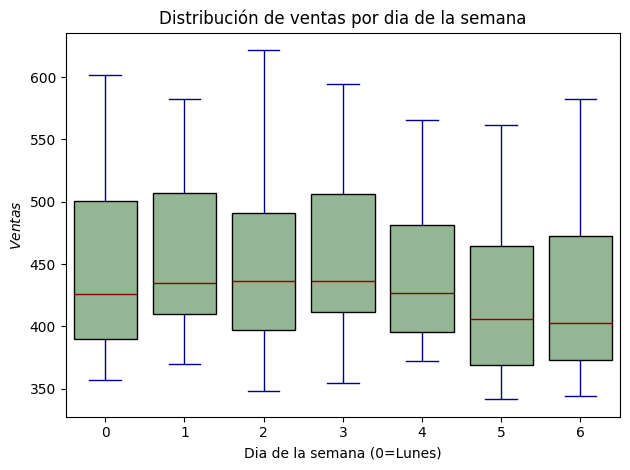

In [75]:
sns.boxplot(x=data.index.dayofweek,y=data['ventas'],color='#8FBC8F',
            boxprops=dict(edgecolor="#000000"),  # borde de la caja
            whiskerprops=dict(color="#00008B"),     # líneas de los bigotes
            capprops=dict(color="#00008B"),         # terminales de los bigotes
            medianprops=dict(color="#8B0000"))     # línea de la mediana)
plt.title('Distribución de ventas por dia de la semana', fontsize=12)
plt.xlabel('Dia de la semana (0=Lunes)', fontsize=10)
plt.ylabel('$Ventas$',fontsize=10)
plt.tight_layout()
plt.show()

###Comparación de densidad para diferencias de 5 a 9

- data['ventas'] - data['ventas'].shift(lag) es igual que data.ventas.diff(lag)

In [82]:
#data.ventas.diff(7)
(data['ventas']-data['ventas'].shift(7)).dropna().head()

,ventas
2024-01-08,-6.439191
2024-01-09,-15.468151
2024-01-10,-12.076927
2024-01-11,-40.296713
2024-01-12,-13.973646


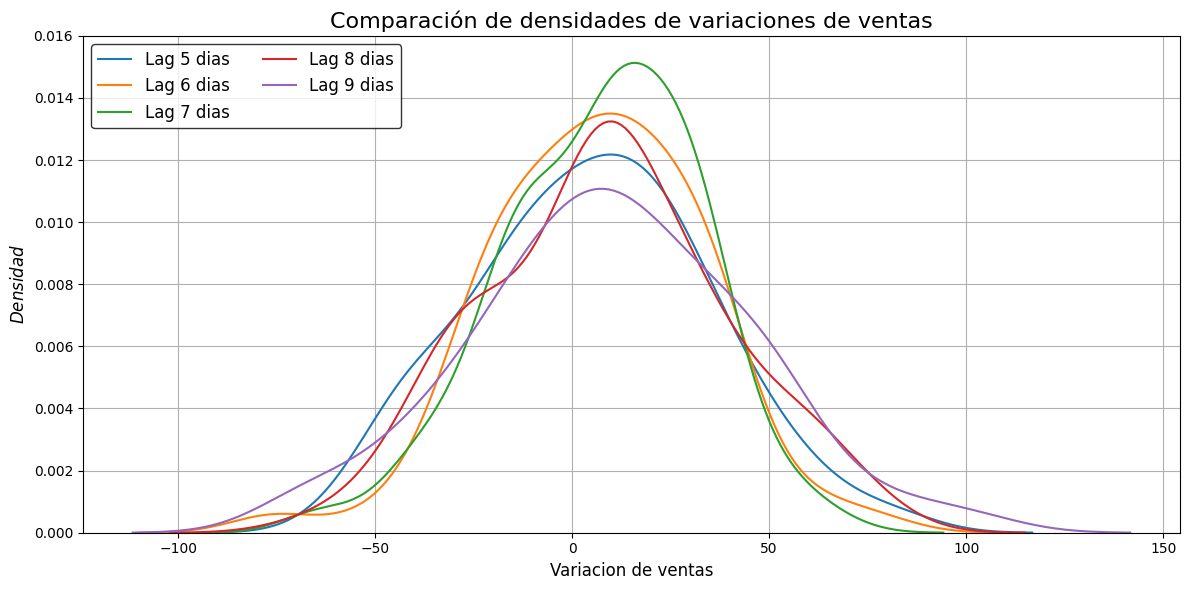

In [103]:
# Crear las diferencias con lags de 5 a 9 días
for lag in range(5,10):
  data[f'diff_{lag}'] = data.ventas.diff(lag)
# Graficar las densidades (KDE) de cada diferencia
# la densidad nos dice la concentracion mas alta de datos
plt.figure(figsize=(12,6))

for lag in range(5,10):
  sns.kdeplot(data[f'diff_{lag}'].dropna(), label=f'Lag {lag} dias')
# kdeplot = densidad kernel (Kernel Density Estimation - KDE), lo estima de forma gaussiana/normal
plt.title('Comparación de densidades de variaciones de ventas',fontsize=16)
plt.xlabel('Variacion de ventas',fontsize=12)
plt.ylabel('$Densidad$',fontsize=12)
plt.legend(loc='upper left',fontsize=12,ncol=2,edgecolor='#000000')
plt.ylim(0,0.016)
plt.grid(True)
plt.tight_layout()
plt.show()

## Descomposición Final
- Ahora que hemos comprobado que la tendencia es lineal y que existe una estacionalidad aditiva con un patrón semanal (7 periodos), procedemos a realizar la descomposición de la serie temporal. Esto nos permitirá separar y analizar de forma individual los componentes de tendencia, estacionalidad y residuo, facilitando una mejor comprensión del comportamiento subyacente de los datos.

In [104]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Aplicar descomposición aditiva
descomposición = seasonal_decompose(data['ventas'],model='additive', period=7)

In [107]:
#seasonal, tren,otros.
descomposición.observed.head()

,ventas
2024-01-01,457.450712
2024-01-02,446.426035
2024-01-03,456.715328
2024-01-04,468.345448
2024-01-05,440.487699


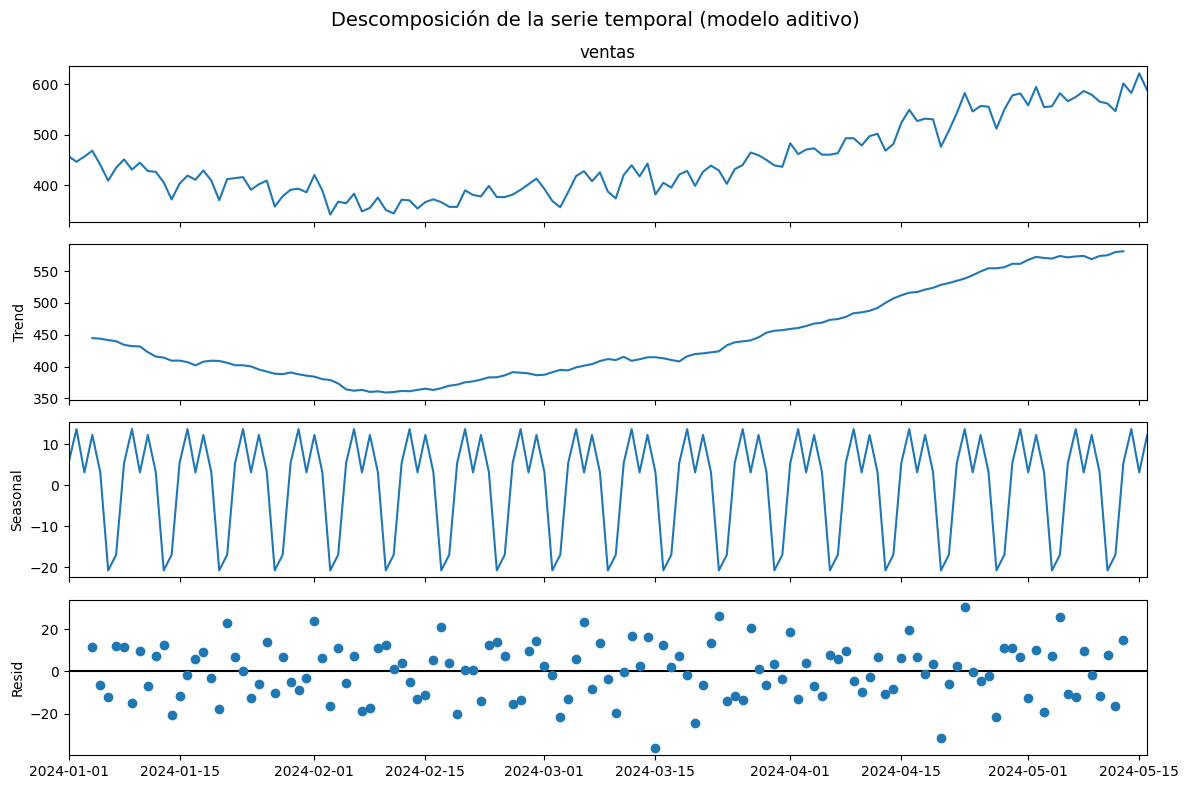

In [111]:
# Graficar los componentes
fig=descomposición.plot()
fig.set_size_inches(12,8) #ajustar el tamaño despues de crear la figura
plt.suptitle('Descomposición de la serie temporal (modelo aditivo)', fontsize=14)
plt.tight_layout()
plt.savefig('descomposicion.png',dpi=400,bbox_inches='tight')
plt.show()